In [56]:
from zipfile import ZipFile
from ast import literal_eval
from IPython.display import display
import re
import pandas as pd
import pytesseract
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from myfunctions import *
import nltk

In [3]:
datadf = pd.read_csv('All Data/Raw Journey Data/Until16May2020(all jsons to csv).csv')
datadf.rename(columns={'Unnamed: 0':'id'}, inplace=True)
datadf.set_index('id', inplace=True)
datadf.head(2)

,text,date_modified,date_journal,address,lat,lon,posture,timezone,favourite,weather,photos,tags,no_punc,is_personal,cleaned_text
id,,,,,,,,,,,,,,,
1439137473084-3fc756cc3f8d6404,"The first thing I saw ,when I entered her room...",2017-08-31 01:44:57,2015-08-09 11:24:33,NaN,1.7976931348623157e+308,1.7976931348623157e+308,0,NaN,False,"{'id': -1, 'degree_c': 1.7976931348623157e+308...",[],"['personal', 'published']",The first thing I saw when I entered her room ...,1,"The first thing I saw , when I entered her roo..."
1439198245820-3fda14add91e3f20,Philosophy\n\n\n\n\n\n\nIt surprises me..hw u ...,2017-08-22 22:08:05,2015-08-10 04:17:25,NaN,1.7976931348623157e+308,1.7976931348623157e+308,0,NaN,False,"{'id': -1, 'degree_c': 1.7976931348623157e+308...",[],['personal'],Philosophy It surprises me hw u so effortlessl...,1,Philosophy It surprises me ... hw you so effor...


In [4]:
home_path = 'All Data/Raw Journey Data/Until16May2020(no HQ media)/'
images = []
for filename in os.listdir(home_path):
    if filename.endswith('.jpg'):
        images.append(filename)

In [5]:
images = pd.DataFrame(images).rename(columns={0:'image_name'})

In [6]:
images['image_text'] = ''
images

,image_name,image_text
0,1543208521055-3fd9ea85cb5b929a-3fe781148bf7bc9...,
1,1588354752808-3fecfbbe72fd40d4-3fda19fb3b16945...,
2,1558470258298-3fe056157ea11b59-3fdb582e8224a20...,
3,1581785142356-3fd0f489ebeb98cc-3fca8c84f27dd6d...,
4,1523113867241-3fe35c12e18113a2-3fdada3afaad314...,
...,...,...
2104,1588780268789-3fe9a7e467669373-3fd0fddd022b9ff...,
2105,1582242709998-3fec42df16c6b008-3fcbe24357e983b...,
2106,1475832629340-3feed134040812d1-3fcb69aa220f411...,
2107,1571356580582-3fb1bc122a8cacd8-3fd22d0d65af4ce...,


In [7]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

climate ©

possible benefits
4 Carbon dioxide
fertilization

Ke

growing

periods
sd

Increased
precipitation

Sr

Increased
flooding and
salinization

 



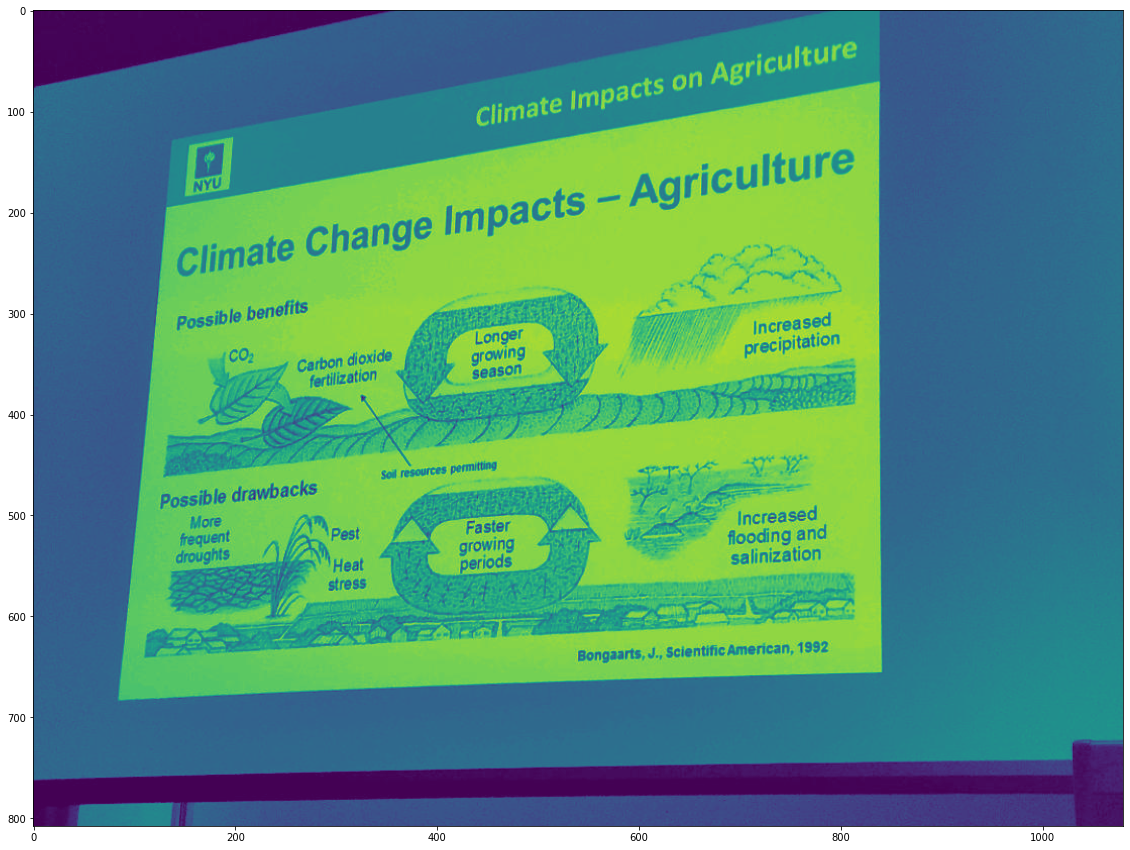

In [26]:
img = cv2.imread(home_path+images.image_name[121],0)
# img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(35,15))
plt.imshow(img)
print(pytesseract.image_to_string(img))

In [42]:
# for i in range(len(images)):  
#     try:
#         print((i/len(images))*100,'% done')
#         img = cv2.imread(home_path+images.image_name[i],0)
#         images['image_text'][i] = pytesseract.image_to_string(img)
#     except:
#         pass 

In [46]:
images

,image_name,image_text
0,1543208521055-3fd9ea85cb5b929a-3fe781148bf7bc9...,0.44K/s ID! © WH 4 53% O 11:38\n\nNyu Lily Joy...
1,1588354752808-3fecfbbe72fd40d4-3fda19fb3b16945...,2:44 4970\n€ ope\n\nCSL Awards Week - You're A...
2,1558470258298-3fe056157ea11b59-3fdb582e8224a20...,\n
3,1581785142356-3fd0f489ebeb98cc-3fca8c84f27dd6d...,11:45 O&O [ORT ay ya 2e)\n\nya VERMONT MEIPIST...
4,1523113867241-3fe35c12e18113a2-3fdada3afaad314...,gGjouMm 1.49 K/s ¥ © MW 4 4 69% O 8:32\n\na) P...
...,...,...
2104,1588780268789-3fe9a7e467669373-3fd0fddd022b9ff...,Teor a |\n\n \n\n€ Q Two App Studio\n\nABOUT J...
2105,1582242709998-3fec42df16c6b008-3fcbe24357e983b...,ee 8 4 58% D\n\nats. CCG\n\n \n\nThey delayed ...
2106,1475832629340-3feed134040812d1-3fcb69aa220f411...,FREEDOM\n
2107,1571356580582-3fb1bc122a8cacd8-3fd22d0d65af4ce...,\n\n| New York City Alliance\nAgainst Sexual ...


In [64]:
images['image_tokens'] = images.image_text.apply(lambda x: nltk.word_tokenize(lemmatize(x)))

In [ ]:
images.to_csv('All Data/Raw Journey Data/Text_from_images_Until16May2020.csv')

In [86]:
image_dict = images[['image_name','image_tokens']].set_index('image_name').to_dict()['image_tokens']

In [72]:
image_tokens = datadf[['photos']].copy()
image_tokens['tokens'] = None
image_tokens

,photos,tokens
id,,
1439137473084-3fc756cc3f8d6404,[],None
1439198245820-3fda14add91e3f20,[],None
1439198461993-3fefd6db711e0342,[],None
1439575035515-3feb330512548cbd,[],None
1440393646546-3fdb2bc02b9f8020,[],None
...,...,...
1589599203833-3fccc2487ff20d88,[],None
1589599469199-3fc8b4cdb6d4b0d4,[],None
1589603430128-3fdcc9774f183676,[],None


In [100]:
for i in range(len(image_tokens)):
    image_tokens['tokens'][i] = []
    for each_filename in literal_eval(image_tokens.photos[i]):
        if each_filename in image_dict.keys():
            image_tokens['tokens'][i] = image_tokens['tokens'][i] + image_dict[each_filename]

In [99]:
image_tokens.to_csv('All Data/Raw Journey Data/Image_tokens_per_entry_Until16May2020.csv')

In [105]:
image_tokens[['enke' in each for each in image_tokens.tokens]].index #this is so so so cool

Index(['1521932454651-3fdc1251b68f2478', '1522286397936-3fe3cd52c03edd47',
       '1527666475282-3fd53a9798723104', '1527673682333-3feb844c87f9d278',
       '1559885634391-3fe4570f7e8b574c'],
      dtype='object', name='id')